In [19]:
import pandas as pd
from pyecharts import Bar, Page
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, \
    plot_precision_recall_curve, classification_report, plot_confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2


'''
feature name      description                 value
bacno             account number              int
txkey             transaction number          int
locdt             transaction date            int 1-90
loctm             transaction time            6 digit int
cano              card number                 int
contp             transaction category        0-6
etymd             transaction type            0-10
mchno             store code                  6 digit int
acqic             acquirer code               int (starts wit 0)
mcc               MCC_CODE                    3 digit int
conam             transaction amount          float
ecfg              online transaction          boolean
insfg             installment                 boolean
iterm             installment terms           0-8   
stocn             transaction country         3 digit int  
scity             transaction city            4 digit int  
stscd             status code                 0-4
ovrlt             overlap                     boolean
flbmk             Fallback                    boolean
hcefg             payment type                0-9
csmcu             transaction currency        0-75       
flg_3dsmk         3DS                         boolean
fraud_ind         fraud transaction           boolean
'''

# categorize transaction amount
def conam_convert(x):
    if x <= 1000:
        return 0
    elif 1000 < x <= 2000:
        return 1
    elif 2000 < x <= 3000:
        return 2
    elif 3000 < x <= 4000:
        return 3
    elif 4000 < x <= 5000:
        return 4
    elif 5000 < x <= 6000:
        return 5
    else:
        return 6

# normalize transaction date
def t2s2(t):
    if len(t) == 1:
        return '00000'+t
    elif len(t) == 2:
        return '0000'+t
    elif len(t) == 3:
        return '000'+t
    elif len(t) == 4:
        return '00'+t
    elif len(t) == 5:
        return '0'+t
    else:
        return t

# create new features
def find_suspecious(df):
    fraud_canos = df[df.fraud_ind==1].cano.unique()
    etymd = df[df.fraud_ind==1].etymd.unique()
    csmcu = df[df.fraud_ind==1].csmcu.unique()
    
    sus_loctm, sus_city = np.zeros(len(df)), np.zeros(len(df))
    sus_etymd, sus_csmcu = np.zeros(len(df)), np.zeros(len(df))
    sus_locdt, tm_3ds_ovr_ecfg = np.zeros(len(df)), np.zeros(len(df))
    ovrlt_ecfg = np.zeros(len(df))
    for card in fraud_canos:
        fraud_card = df[df.cano==card]
        ids = np.array(fraud_card.index)
        fraud_card = fraud_card[['locdt', 'fraud_ind', 'scity', 'mchno', 'loctm', 'etymd', 
                                 'ecfg', 'conam', 'csmcu', 'locmin', 'flg_3dsmk', 'ovrlt']].values
        for i in range(len(fraud_card)):
            id1 = ids[i]
            if i+1 < len(fraud_card):
                if fraud_card[i+1, 0] - fraud_card[i, 0] <= 4 and fraud_card[i+1, 1]==fraud_card[i, 1]:
                    if fraud_card[i+1, 4] - fraud_card[i, 4] < 12:
                        sus_loctm[id1] = 1
                
                if fraud_card[i+1, 2]==fraud_card[i, 2]:
                    if fraud_card[i+1, 1]==1 or fraud_card[i, 1]==1:
                        if fraud_card[i+1, 3]==fraud_card[i, 3]:
                            sus_city[id1] = 1
                
                if fraud_card[i+1, 5] in etymd or fraud_card[i, 5] in etymd:
                    if fraud_card[i+1, 1]==1 or fraud_card[i, 1]==1 and fraud_card[i+1, 0] - fraud_card[i, 0] <= 4:
                        if fraud_card[i+1, 4] <= 7 or fraud_card[i+1, 4] >= 23 and fraud_card[i+1, 9] <= 30:
                            if fraud_card[i, 4] <= 7 or fraud_card[i, 4] >= 23 and fraud_card[i, 9] <= 30:
                                sus_etymd[id1] = 1
                
                if fraud_card[i+1, 8] in csmcu or fraud_card[i, 8] in csmcu:
                    if fraud_card[i+1, 1]==1 or fraud_card[i, 1]==1 and fraud_card[i+1, 6]==fraud_card[i, 6]:
                        if fraud_card[i+1, 7] <= 3500 and fraud_card[i, 7] <= 3500:
                            sus_csmcu[id1] = 1
                            
                if fraud_card[i+1, 0] - fraud_card[i, 0] <= 4 or fraud_card[i+1, 0] - fraud_card[i, 0] > 6:
                    if fraud_card[i+1, 1]==1 or fraud_card[i, 1]==1:
                        sus_locdt[id1] = 1
                
                if fraud_card[i+1, 10]==fraud_card[i, 10] or fraud_card[i+1, 6]==fraud_card[i, 6] \
                    or fraud_card[i+1, 11]==fraud_card[i, 11]:
                    if fraud_card[i+1, 1]==1 or fraud_card[i, 1]==1:
                        if fraud_card[i+1, 4] <= 7 and fraud_card[i, 4] <= 7:
                            tm_3ds_ovr_ecfg[ids] = 1
                
                if fraud_card[i+1, 11]==fraud_card[i, 11] and fraud_card[i+1, 6]==fraud_card[i, 6]:
                    if fraud_card[i+1, 1]==1 or fraud_card[i, 1]==1:
                            ovrlt_ecfg[ids] = 1
            else:
                if fraud_card[i, 1]==1:
                    sus_loctm[id1] = 1
                    sus_city[id1] = 1
                    if fraud_card[i, 5] in etymd:
                        if fraud_card[i, 4] <= 7 or fraud_card[i, 4] >= 23 and fraud_card[i, 9] <= 30:
                            sus_etymd[id1] = 1
                    if fraud_card[i, 6]==1 and fraud_card[i, 7] <= 3500 and fraud_card[i, 8] in csmcu:
                        sus_csmcu[id1] = 1
                    if fraud_card[i, 10]==1 and fraud_card[i, 4] <= 7 or fraud_card[i, 6]==1 or fraud_card[i, 11]==1:
                        tm_3ds_ovr_ecfg[ids] = 1
                    if fraud_card[i, 6]==1 and fraud_card[i, 11]==1:
                        ovrlt_ecfg[ids] = 1
    return sus_loctm, sus_city, sus_etymd, sus_csmcu, sus_locdt, tm_3ds_ovr_ecfg, ovrlt_ecfg

In [20]:
# read file
path = 'C:/Users/firze/Documents/Programming/creditcard/'
df = pd.read_csv(path+'train.csv')
print('Read data done.')

Read data done.


In [21]:
### clean data
## clean missing values
# check if data has null values
print('Nulls:')
print(df.isnull().sum())

tb1, tb2 = df[df.flbmk == 'N'], df[df.flbmk == 'Y']
bar1 = Bar('Relationship between Fallback & Fraud rate' , width=800, height=600)
bar1.add('', ['Fallback = 0', 'Fallback = 1'], 
         [round(len(100*tb1[tb1.fraud_ind==1])/len(tb1), 2), round(100*len(tb2[tb2.fraud_ind==1])/len(tb2), 2)], 
         xaxis_name='feature type', yaxis_name='fraud rate')
page.add(bar1)

df = df.fillna(1)

## replace string data
df = df.apply(lambda x:x.replace('N', 0))
df = df.apply(lambda x:x.replace('Y', 1))

## convert time formats
df.loctm = df.loctm.apply(lambda x:t2s2(str(int(x))))
df.insert(16, 'locmin', df.loctm.apply(lambda x:int(x[2:4])))  # insert transaction minute data
df.loctm = df.loctm.apply(lambda x:int(x[:2]))                 # convert transation time to hour

## replace mismatch data
df.loc[(df.iterm==0), 'iterm'] = 4

## sort by locdt to split data
df.index = df.locdt
df.sort_index(inplace=True)
df.index = range(len(df))

Nulls:
acqic            0
bacno            0
cano             0
conam            0
contp            0
csmcu            0
ecfg             0
etymd            0
flbmk        12581
flg_3dsmk    12581
fraud_ind        0
hcefg            0
insfg            0
iterm            0
locdt            0
loctm            0
mcc              0
mchno            0
ovrlt            0
scity            0
stocn            0
stscd            0
txkey            0
dtype: int64


In [22]:
### split data into training and testing sets
training_ratio = 1521787/(1521787+421665)
training_size = round(df.shape[0]*training_ratio)
train, test = df.head(training_size), df.tail(df.shape[0]-training_size)
test.index = range(len(test))
print('Split data done.')

Split data done.


In [23]:
### EDA
## covariance matrix (before)
corr = df.corr()
print(corr)

page = Page()

t1 = train[['loctm', 'fraud_ind']]
s1 = t1[t1.fraud_ind==1].groupby('loctm').count().rename(columns={'fraud_ind':'n'})
s2 = t1.groupby('loctm').count().rename(columns={'fraud_ind':'n'})
bar3 = Bar('Fraud transaction distribution', width=800, height=600)
bar3.add('', s1.index, round(100*s1.n/s2.n, 2), xaxis_name='time', yaxis_name='fraud rate', 
         mark_line=["average"])
page.add(bar3)

t2 = train[['ecfg', 'fraud_ind']]
s3 = t2[t2.fraud_ind==1].groupby('ecfg').count().rename(columns={'fraud_ind':'n'})
s4 = t2.groupby('ecfg').count().rename(columns={'fraud_ind':'n'})
bar4 = Bar('Fraud online transaction distribution', width=800, height=600)
bar4.add('', s3.index, round(100*s3.n/s4.n, 2), xaxis_name='online transaction(N/Y)', yaxis_name='fraud rate', 
         mark_line=["average"])
page.add(bar4)

t3 = train[train.ecfg==1]
t3 = t3[['loctm', 'fraud_ind']]
s5 = t3[t3.fraud_ind==1].groupby('loctm').count().rename(columns={'fraud_ind':'n'})
s6 = t3.groupby('loctm').count().rename(columns={'fraud_ind':'n'})
bar5 = Bar('Fraud online transaction time distribution', width=800, height=600)
bar5.add('', s5.index, round(100*s5.n/s6.n, 2), xaxis_name='online transaction time', yaxis_name='fraud rate', 
         mark_line=["average"])
page.add(bar5)

t4 = train[train.flg_3dsmk==1]
t4 = t4[['loctm', 'fraud_ind']]
s7 = t4[t4.fraud_ind==1].groupby('loctm').count().rename(columns={'fraud_ind':'n'})
s8 = t4.groupby('loctm').count().rename(columns={'fraud_ind':'n'})
for i in s8.index:
    if i not in s7.index:
        s7.loc[i, 'n'] = 0
s7.sort_index(inplace=True)
bar6 = Bar('Fraud 3DS time distribution', width=800, height=600)
bar6.add('', s7.index, round(100*s7.n/s8.n, 2), xaxis_name='3DS time', yaxis_name='fraud rate', 
         mark_line=["average"])
page.add(bar6)

t5 = train[train.ovrlt==1]
t5 = t5[['loctm', 'fraud_ind']]
s9 = t5[t5.fraud_ind==1].groupby('loctm').count().rename(columns={'fraud_ind':'n'})
s10 = t5.groupby('loctm').count().rename(columns={'fraud_ind':'n'})
bar7 = Bar('Overlap time distribution', width=800, height=600)
bar7.add('', s9.index, round(100*s9.n/s10.n, 2), xaxis_name='overlap time', yaxis_name='fraud rate', 
         mark_line=["average"])
page.add(bar7)

t6 = train[['conam', 'fraud_ind']]
t6.insert(0, 'new_conam', [conam_convert(x) for x in t6.conam])
s11 = t6[t6.fraud_ind==1].groupby('new_conam').count().rename(columns={'fraud_ind':'n'})
s12 = t6.groupby('new_conam').count().rename(columns={'fraud_ind':'n'})
for i in s12.index:
    if i not in s11.index:
        s11.loc[i, 'n'] = 0
s11.sort_index(inplace=True)
bar8 = Bar('Fraud amout', width=800, height=600)
bar8.add('', s11.index, round(100*s11.n/s12.n, 2), xaxis_name='amount', yaxis_name='fraud rate', 
         mark_line=["average"])
page.add(bar8)

page.render('Credit card fraud detectio EDA.html')

              acqic     bacno      cano     conam     contp     csmcu  \
acqic      1.000000 -0.007525 -0.056867  0.125105 -0.049862  0.409295   
bacno     -0.007525  1.000000  0.001098  0.005563 -0.003440 -0.007526   
cano      -0.056867  0.001098  1.000000 -0.064126 -0.001416 -0.029720   
conam      0.125105  0.005563 -0.064126  1.000000  0.016782  0.140327   
contp     -0.049862 -0.003440 -0.001416  0.016782  1.000000 -0.097577   
csmcu      0.409295 -0.007526 -0.029720  0.140327 -0.097577  1.000000   
ecfg      -0.114581 -0.007650  0.057119 -0.054025  0.127140  0.156022   
etymd     -0.022268 -0.012441  0.009841 -0.003936  0.149566  0.496671   
flbmk      0.012656 -0.003338  0.020929 -0.035155  0.021013  0.089857   
flg_3dsmk  0.050132 -0.004876  0.036844  0.017134  0.054246  0.110041   
fraud_ind -0.083684  0.000285  0.004608  0.016634  0.023248  0.013472   
hcefg      0.561495 -0.009272 -0.024966  0.126972 -0.042777  0.409084   
insfg      0.075631  0.000097 -0.037620  0.227126  

In [24]:
### feature engineering
fraud_canos = train[train.fraud_ind==1].cano.unique()
dup_col = ['cano', 'contp', 'csmcu', 'ecfg', 'etymd', 'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'iterm', 'mcc', 'stocn', 
           'stscd', 'mchno', 'scity', 'ovrlt']

sus_loctm, sus_city, sus_etymd, sus_csmcu, sus_locdt, tm_3ds_ovr_ecfg, ovrlt_ecfg = find_suspecious(train)
train.insert(0, 'sus_loctm', sus_loctm)
train.insert(0, 'sus_city', sus_city)
train.insert(0, 'sus_etymd', sus_etymd)
train.insert(0, 'sus_csmcu', sus_csmcu)
train.insert(0, 'sus_locdt', sus_locdt)
train.insert(0, 'tm_3ds_ovr_ecfg', tm_3ds_ovr_ecfg)
train.insert(0, 'ovrlt_ecfg', ovrlt_ecfg)
train.insert(0, 'sus', pd.Series((train.cano.isin(fraud_canos) & train.duplicated(dup_col))).astype('int'))
train.insert(0, 'fraud_conam', pd.Series((train.conam <= 3500)).astype('int'))
train.insert(0, 'sus_sus_loctm', pd.Series((train.sus==1) & (train.sus_loctm==1)).astype('int'))

sus_loctm, sus_city, sus_etymd, sus_csmcu, sus_locdt, tm_3ds_ovr_ecfg, ovrlt_ecfg = find_suspecious(test)
test.insert(0, 'sus_loctm', sus_loctm)
test.insert(0, 'sus_city', sus_city)
test.insert(0, 'sus_etymd', sus_etymd)
test.insert(0, 'sus_csmcu', sus_csmcu)
test.insert(0, 'sus_locdt', sus_locdt)
test.insert(0, 'tm_3ds_ovr_ecfg', tm_3ds_ovr_ecfg)
test.insert(0, 'ovrlt_ecfg', ovrlt_ecfg)
test.insert(0, 'sus', pd.Series((test.cano.isin(fraud_canos) & test.duplicated(dup_col))).astype('int'))
test.insert(0, 'fraud_conam', pd.Series((test.conam <= 3500)).astype('int'))
test.insert(0, 'sus_sus_loctm', pd.Series((test.sus==1) & (test.sus_loctm==1)).astype('int'))

## first reindex
reset_cols = ['fraud_ind', 'sus', 'sus_loctm', 'sus_sus_loctm', 'sus_city', 'stscd', 'sus_locdt', 'tm_3ds_ovr_ecfg', 
              'ovrlt_ecfg', 'ecfg', 'csmcu',  'fraud_conam', 'sus_etymd', 'sus_csmcu']
              #'stocn', 'ovrlt', 'contp', 'scity', 'insfg', 'flbmk', 'flg_3dsmk', 'etymd', 'hcefg']
train = train.reindex(reset_cols, axis=1)
test = test.reindex(reset_cols, axis=1)

## feature selection
para = SelectKBest(chi2, k=13).fit(train, train.fraud_ind).get_support()
columns = [train.columns[i] for i in range(train.shape[1]) if para[i]==1]

## second reindex
train = train.reindex(columns, axis=1)
test = test.reindex(columns, axis=1)

train_x, train_y = train.drop(['fraud_ind'], axis=1), train.fraud_ind
test_x, test_y = test.drop(['fraud_ind'], axis=1), test.fraud_ind

# covariance matrix (after)
corr = train.corr()
print(corr)

print('\nFeature engineering done.')
print('Trainning set fraud rate = ', round(100*train_y.sum()/train_y.shape[0], 4))
print('Testing set fraud rate = ', round(100*test_y.sum()/test_y.shape[0], 4))

                 fraud_ind       sus  sus_loctm  sus_sus_loctm  sus_city  \
fraud_ind         1.000000  0.272771   0.349996       0.234595  0.781701   
sus               0.272771  1.000000   0.541104       0.853437  0.261523   
sus_loctm         0.349996  0.541104   1.000000       0.642648  0.323694   
sus_sus_loctm     0.234595  0.853437   0.642648       1.000000  0.237559   
sus_city          0.781701  0.261523   0.323694       0.237559  1.000000   
stscd             0.293985  0.170898   0.235608       0.148251  0.254802   
sus_locdt         0.646845  0.264098   0.181543       0.124864  0.496717   
tm_3ds_ovr_ecfg   0.375673  0.473121   0.657948       0.410985  0.356729   
ovrlt_ecfg        0.385970  0.581646   0.732194       0.497554  0.331739   
ecfg              0.164453  0.168794   0.157205       0.148781  0.145434   
csmcu             0.013834  0.013883   0.027991       0.012233  0.014853   
sus_etymd         0.472024  0.143736   0.176216       0.110326  0.430622   
sus_csmcu   

Training start.

Results:
Accuracy =  0.9989
Precision =  0.9667
Recall =  0.9121
F1 score =  0.9386
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    327061
           1       0.97      0.91      0.94      3117

    accuracy                           1.00    330178
   macro avg       0.98      0.96      0.97    330178
weighted avg       1.00      1.00      1.00    330178



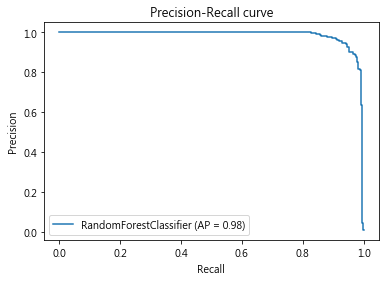

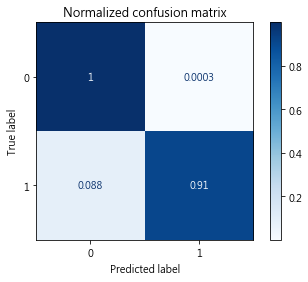

Accuracy =  0.9989
Precision =  0.9667
Recall =  0.9121
F1 score =  0.9386
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    327061
           1       0.97      0.91      0.94      3117

    accuracy                           1.00    330178
   macro avg       0.98      0.96      0.97    330178
weighted avg       1.00      1.00      1.00    330178



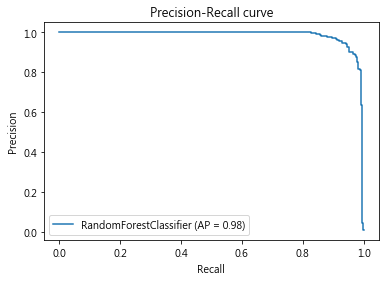

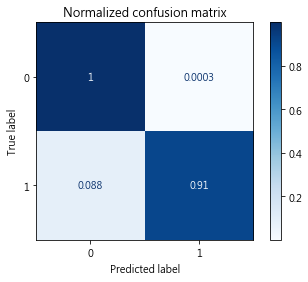

In [25]:
### Training 
print('Training start.')
prediction(train_x, train_y, test_x, test_y)

model = RandomForestClassifier(n_estimators = 200, max_depth=50, random_state=0).fit(train_x, train_y)
pred_y = model.predict(test_x)

### Evaluation
print('\nResults:')
print('Accuracy = ',  round(accuracy_score(test_y, pred_y), 4))
print('Precision = ', round(precision_score(test_y, pred_y), 4))
print('Recall = ',    round(recall_score(test_y, pred_y), 4))
print('F1 score = ',  round(f1_score(test_y, pred_y), 4))
print(classification_report(test_y, pred_y))

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
disp = plot_precision_recall_curve(model, test_x, test_y)
disp.ax_.set_title('Precision-Recall curve')
#plt.savefig('Precision-Recall curve.png')
plt.show()

disp = plot_confusion_matrix(model, test_x, test_y, display_labels=['0', '1'], cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title("Normalized confusion matrix")
#plt.savefig('Confusion Matrix.png')
plt.show()